# 1.Lenet5

手写数字被数字化为像素大小的灰度图像--32×32。那时，计算能力有限，因此该技术无法扩展到大规模图像。

该模型包含7层（不包括输入层）。由于它是一个相对较小的架构，让我们逐层解释：
1. 第1层：卷积层，核大小为5×5，步长为1×1，总共为6个核。因此，大小为32x32x1的输入图像的输出为28x28x6。层中的总参数= 5 * 5 * 6 + 6（偏差项）
2. 第2层：具有2×2核大小的池化层，总共2×2和6个核。这个池化层的行为与之前的文章略有不同。将接收器中的输入值相加，然后乘以可训练参数（每个filter 1个），最后将结果加到可训练的偏差（每个filter 1个）。最后，将sigmoid激活应用于输出。因此，来自前一层大小为28x28x6的输入被子采样为14x14x6。层中的总参数= [1（可训练参数）+ 1（可训练偏差）] * 6 = 12
3. 第3层：与第1层类似，此层是具有相同配置的卷积层，除了它有16个filters而不是6个。因此，前一个大小为14x14x6的输入提供10x10x16的输出。层中的总参数= 5 * 5 * 16 + 16 = 416。
4. 第4层：与第2层类似，此层是一个池化层，这次有16个filters。请记住，输出通过sigmoid激活函数传递。来自前一层的大小为10x10x16的输入被子采样为5x5x16。层中的总参数=（1 + 1）* 16 = 32
5. 第5层：卷积层，核大小为5×5，filters为120。由于输入大小为5x5x16，因此我们无需考虑步幅，因此输出为1x1x120。层中的总参数= 5 * 5 * 120 = 3000
6. 第6层：这是一个包含84个参数的dense层。因此，120个units的输入转换为84个units。总参数= 84 * 120 + 84 = 10164.此处使用的激活函数相当独特。我要说的是，你可以在这里尝试你的任何选择，因为按照今天的标准，这个任务非常简单。
7. 输出层：最后，使用具有10个units的dense层。总参数= 84 * 10 + 10 = 924。
跳过所使用的损失函数的细节及其使用原因，我建议在最后一层使用softmax激活的交叉熵损失。尝试不同的训练计划和学习率。

In [3]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [6]:
def lenet5(in_shape=(32,32,1),n_classes=10):
    in_layer=layers.Input(shape=in_shape)
    conv1 = layers.Conv2D(filters=6,kernel_size=5,padding='same',activation='relu')(in_layer)
    pool1 = layers.MaxPooling2D(pool_size=2,strides=2)(conv1)
    conv2 = layers.Conv2D(filters=16,kernel_size=5,padding='same',activation='relu')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=2,strides=2)(conv2)
    flatten = layers.Flatten()(pool2)
    dense1= layers.Dense(500,activation='relu')(flatten)
    logits = layers.Dense(n_classes,activation='softmax')(dense1)
    model = Model(in_layer,logits)
    return model
model = lenet5()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 6)         156       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 16)        2416      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               512500

# 2.AlexNet

2012年，Hinton的深度神经网络将世界上最重要的计算机视觉挑战图像网络中的损失从26％减少到15.3％。

该网络与LeNet非常相似，但更深，拥有大约6000万个参数。作者使用了各种其他技术 - dropout，augmentation 和Stochastic Gradient Descent with momentum。
- 5个卷积层，3个全连接层，参数量60M。
- 激活函数是Relu:f(x)=max(0,x)
- 使用了数据增强：从原始图像（256x256）中截取224x224大小的区域，并进行水平翻转，将一张图片变成了2048（2*(256-224)^2）张图片，测试时以图片4个角落和中心点为基准，获取切割区域，并进行水平翻转，1张测试图片变为10张图片。
- 使用dropout防止过拟合
- 使用max pooling。之前CNN普遍使用平均池化，AlexNet全部使用max pooling，避免平均池化的模糊效果。
- 双GPU实现。
- 使用LRN,对局部神经元的活动创建竞争机制，使得其中响应比较大的值变得相对更大，并抑制其他反馈较小的神经元，增强了模型的泛化能力。
- 



In [8]:
def alexnet(in_shape=(224,224,3),n_classes=1000):
    in_layer = layers.Input(in_shape)
    conv1 = layers.Conv2D(96, 11, strides=4, activation='relu')(in_layer)
    pool1 = layers.MaxPool2D(3, 2)(conv1)
    conv2 = layers.Conv2D(256, 5, strides=1, padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPool2D(3, 2)(conv2)
    conv3 = layers.Conv2D(384, 3, strides=1, padding='same', activation='relu')(pool2)
    conv4 = layers.Conv2D(256, 3, strides=1, padding='same', activation='relu')(conv3)
    pool3 = layers.MaxPool2D(3, 2)(conv4)
    flattened = layers.Flatten()(pool3)
    dense1 = layers.Dense(4096, activation='relu')(flattened)
    drop1 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(4096, activation='relu')(drop1)
    drop2 = layers.Dropout(0.5)(dense2)
    preds = layers.Dense(n_classes, activation='softmax')(drop2)
    model = Model(in_layer, preds)
    return model
model = alexnet()
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 256)       8849

# 3.VGG

2014年imagenet挑战的亚军被命名为VGGNet。由于其简单的统一结构，它以更简单的形式提出了一种更简单的深度卷积神经网络的形式。
VGGNet有两条简单的经验法则：
- 每个卷积层都有配置 - 核大小= 3×3，stride = 1×1，padding = same。唯一不同的是filters的数量。
- 每个Max Pooling层都有配置 - windows size= 2×2和stride = 2×2。因此，我们在每个Pooling层的图像大小减半。
关于模型有几点说明：
- 主要是VGG16和VGG19， 前者参数量是138M。
- 大量使用3x3的卷积核。这里有一个知识点：stride都为1时，两个3x3的卷积核的感受野等于一个5x5的卷积核，三个3x3卷积核的感受野等于一个7x7的卷积核。为什么要用小卷积核呢？原因是：（1）减少参数量。两个3x3的卷积核参数量为3x3x2=18，一个5x5的卷积核参数量为25。（2）深度增加了，相当于增加了非线性拟合能力。
- VGGNet探索了卷积神经网络的深度与其性能之间的关系，通过反复堆叠3x3的小型卷积核和2x2的最大池化层，VGGNet成功地构筑了16~19层深的卷积神经网络。
- 优化方法：含有动量的随机梯度下降 (SGD+momentum)。
- 数据增强：训练数据采用Multi-Scale方法，原始图像被缩放到S(256,512)，然后随机Scale到尺寸Q(224x224)。
- 总参数= 1.38亿。大多数这些参数由全连接层贡献。第一个FC层= 4096 *（7 * 7 * 512）+ 4096 = 102,764,544，第二个FC层= 4096 * 4096 + 4096 = 16,781,312， 第三个FC层= 4096 * 1000 + 4096 = 4,100,096，FC层贡献的总参数= 123,645,952。

In [9]:
from functools import partial

In [13]:
conv3 = partial(layers.Conv2D,kernel_size=3,strides=1,padding='same',activation='relu')

def block(in_tensor, filters, n_convs):
    conv_block = in_tensor
    for _ in range(n_convs):
        conv_block = conv3(filters=filters)(conv_block)

    return conv_block

def _vgg(in_shape=(224,224,3),n_classes=1000,n_stages_per_blocks=[2, 2, 3, 3, 3]):
    in_layer = layers.Input(in_shape)
    block1 = block(in_layer, 64, n_stages_per_blocks[0])
    pool1 = layers.MaxPooling2D()(block1)
    block2 = block(pool1, 128, n_stages_per_blocks[1])
    pool2 = layers.MaxPooling2D()(block2)
    block3 = block(pool2, 256, n_stages_per_blocks[2])
    pool3 = layers.MaxPooling2D()(block3)
    block4 = block(pool3, 512, n_stages_per_blocks[3])
    pool4 = layers.MaxPooling2D()(block4)
    block5 = block(pool4, 512, n_stages_per_blocks[4])
    pool5 = layers.MaxPooling2D()(block5)
#     flattened = layers.GlobalAvgPool2D()(pool5)
    flattened = layers.Flatten()(pool5)
    dense1 = layers.Dense(4096, activation='relu')(flattened)
    dense2 = layers.Dense(4096, activation='relu')(dense1)
    preds = layers.Dense(1000, activation='softmax')(dense2)
    model = Model(in_layer, preds)
    
    return model
def vgg16(in_shape=(224,224,3), n_classes=1000):
    return _vgg(in_shape, n_classes)

def vgg19(in_shape=(224,224,3), n_classes=1000):
    return _vgg(in_shape, n_classes, [2, 2, 4, 4, 4])
model = vgg16()
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 56, 56, 128)       0   

# 4. Inception系列（v1到v4)

## 4.1 Inceptionv1(GoogLeNet)

关于模型有几点：
- 使用多个“辅助分类器”，增加中间层的辅助分类器，增强模型在低阶段层的识别，增加反向传播梯度信号，并提供附加的正则。较深的网络中，越向前梯度的值越小，使得很难学习，因此较早的分类层通过传播强梯度信号来训练网络而变得有用;:深度神经网络往往overfit(或导致高方差)数据,同时小神经网络往往underfit(或导致高偏差)。较早的分类器规范了更深层的过度拟合效果
- 它使用了一个inception 模块，一个新颖的概念，inception模块在一层里使用1x1, 3x3, 5x5的卷积和3x3的maxpooling，然后concatenate一起具有较小的卷积，允许将参数数量减少到仅400万，Inception module的原因：1、每个层类型从输入中提取不同的信息。从3×3层收集的信息将与从5×5层收集的信息不同。我们怎么知道哪一种transformation 是最好的呢?所以我们全部使用它们 2、使用1×1卷积减少尺寸！考虑一个128x128x256输入。如果我们通过20个大小为1×1的过滤器，我们将获得128x128x20的输出。因此，我们在3×3或5×5卷积之前应用它们，以减少用于降维的inception block中这些层的输入filters的数量可以跨通道组织信息，提高网络的表达能力，还可以进行输出通道的升维和降维 3、增加网络宽度，提高特征表达能力； 4、增加了网络对尺度的适应能力，相当于一种多尺度方法


In [24]:
from functools import partial

conv1x1 = partial(layers.Conv2D, kernel_size=1, activation='relu')
conv3x3 = partial(layers.Conv2D, kernel_size=3, padding='same', activation='relu')
conv5x5 = partial(layers.Conv2D, kernel_size=5, padding='same', activation='relu')

def inception_module(in_tensor, c1, c3_1, c3, c5_1, c5, pp):
    conv1 = conv1x1(c1)(in_tensor)
    conv3_1 = conv1x1(c3_1)(in_tensor)
    conv3 = conv3x3(c3)(conv3_1)
    conv5_1 = conv1x1(c5_1)(in_tensor)
    conv5 = conv5x5(c5)(conv5_1)
    pool_conv = conv1x1(pp)(in_tensor)
    pool = layers.MaxPool2D(3, strides=1, padding='same')(pool_conv)
    merged = layers.Concatenate(axis=-1)([conv1, conv3, conv5, pool])
    return merged

def aux_clf(in_tensor):
    avg_pool = layers.AvgPool2D(5, 3)(in_tensor)
    conv = conv1x1(128)(avg_pool)
    flattened = layers.Flatten()(conv)
    dense = layers.Dense(1024, activation='relu')(flattened)
    dropout = layers.Dropout(0.7)(dense)
    out = layers.Dense(1000, activation='softmax')(dropout)
    return out

def inception_net(in_shape=(224,224,3), n_classes=1000):
    in_layer = layers.Input(in_shape)
    conv1 = layers.Conv2D(64, 7, strides=2, activation='relu', padding='same')(in_layer)
    pad1 = layers.ZeroPadding2D()(conv1)
    pool1 = layers.MaxPool2D(3, 2)(pad1)
    conv2_1 = conv1x1(64)(pool1)
    conv2_2 = conv3x3(192)(conv2_1)
    pad2 = layers.ZeroPadding2D()(conv2_2)
    pool2 = layers.MaxPool2D(3, 2)(pad2)
    inception3a = inception_module(pool2, 64, 96, 128, 16, 32, 32)
    inception3b = inception_module(inception3a, 128, 128, 192, 32, 96, 64)
    pad3 = layers.ZeroPadding2D()(inception3b)
    pool3 = layers.MaxPool2D(3, 2)(pad3)
    inception4a = inception_module(pool3, 192, 96, 208, 16, 48, 64)
    inception4b = inception_module(inception4a, 160, 112, 224, 24, 64, 64)
    inception4c = inception_module(inception4b, 128, 128, 256, 24, 64, 64)
    inception4d = inception_module(inception4c, 112, 144, 288, 32, 48, 64)
    inception4e = inception_module(inception4d, 256, 160, 320, 32, 128, 128)
    pad4 = layers.ZeroPadding2D()(inception4e)
    pool4 = layers.MaxPool2D(3, 2)(pad4)
    aux_clf1 = aux_clf(inception4a)
    aux_clf2 = aux_clf(inception4d)
    inception5a = inception_module(pool4, 256, 160, 320, 32, 128, 128)
    inception5b = inception_module(inception5a, 384, 192, 384, 48, 128, 128)
    avg_pool = layers.GlobalAvgPool2D()(inception5b)
    dropout = layers.Dropout(0.4)(avg_pool)
    preds = layers.Dense(1000, activation='softmax')(dropout)
    model = Model(in_layer, [preds, aux_clf1, aux_clf2])
    return model
model = inception_net()
model.summary()

(None, 1024)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_416 (Conv2D)             (None, 112, 112, 64) 9472        input_11[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, 114, 114, 64) 0           conv2d_416[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_99 (MaxPooling2D) (None, 56, 56, 64)   0           zero_padding2d_35[0][0]          
_______________________________________________________________________________

In [15]:
import tensorflow as tf


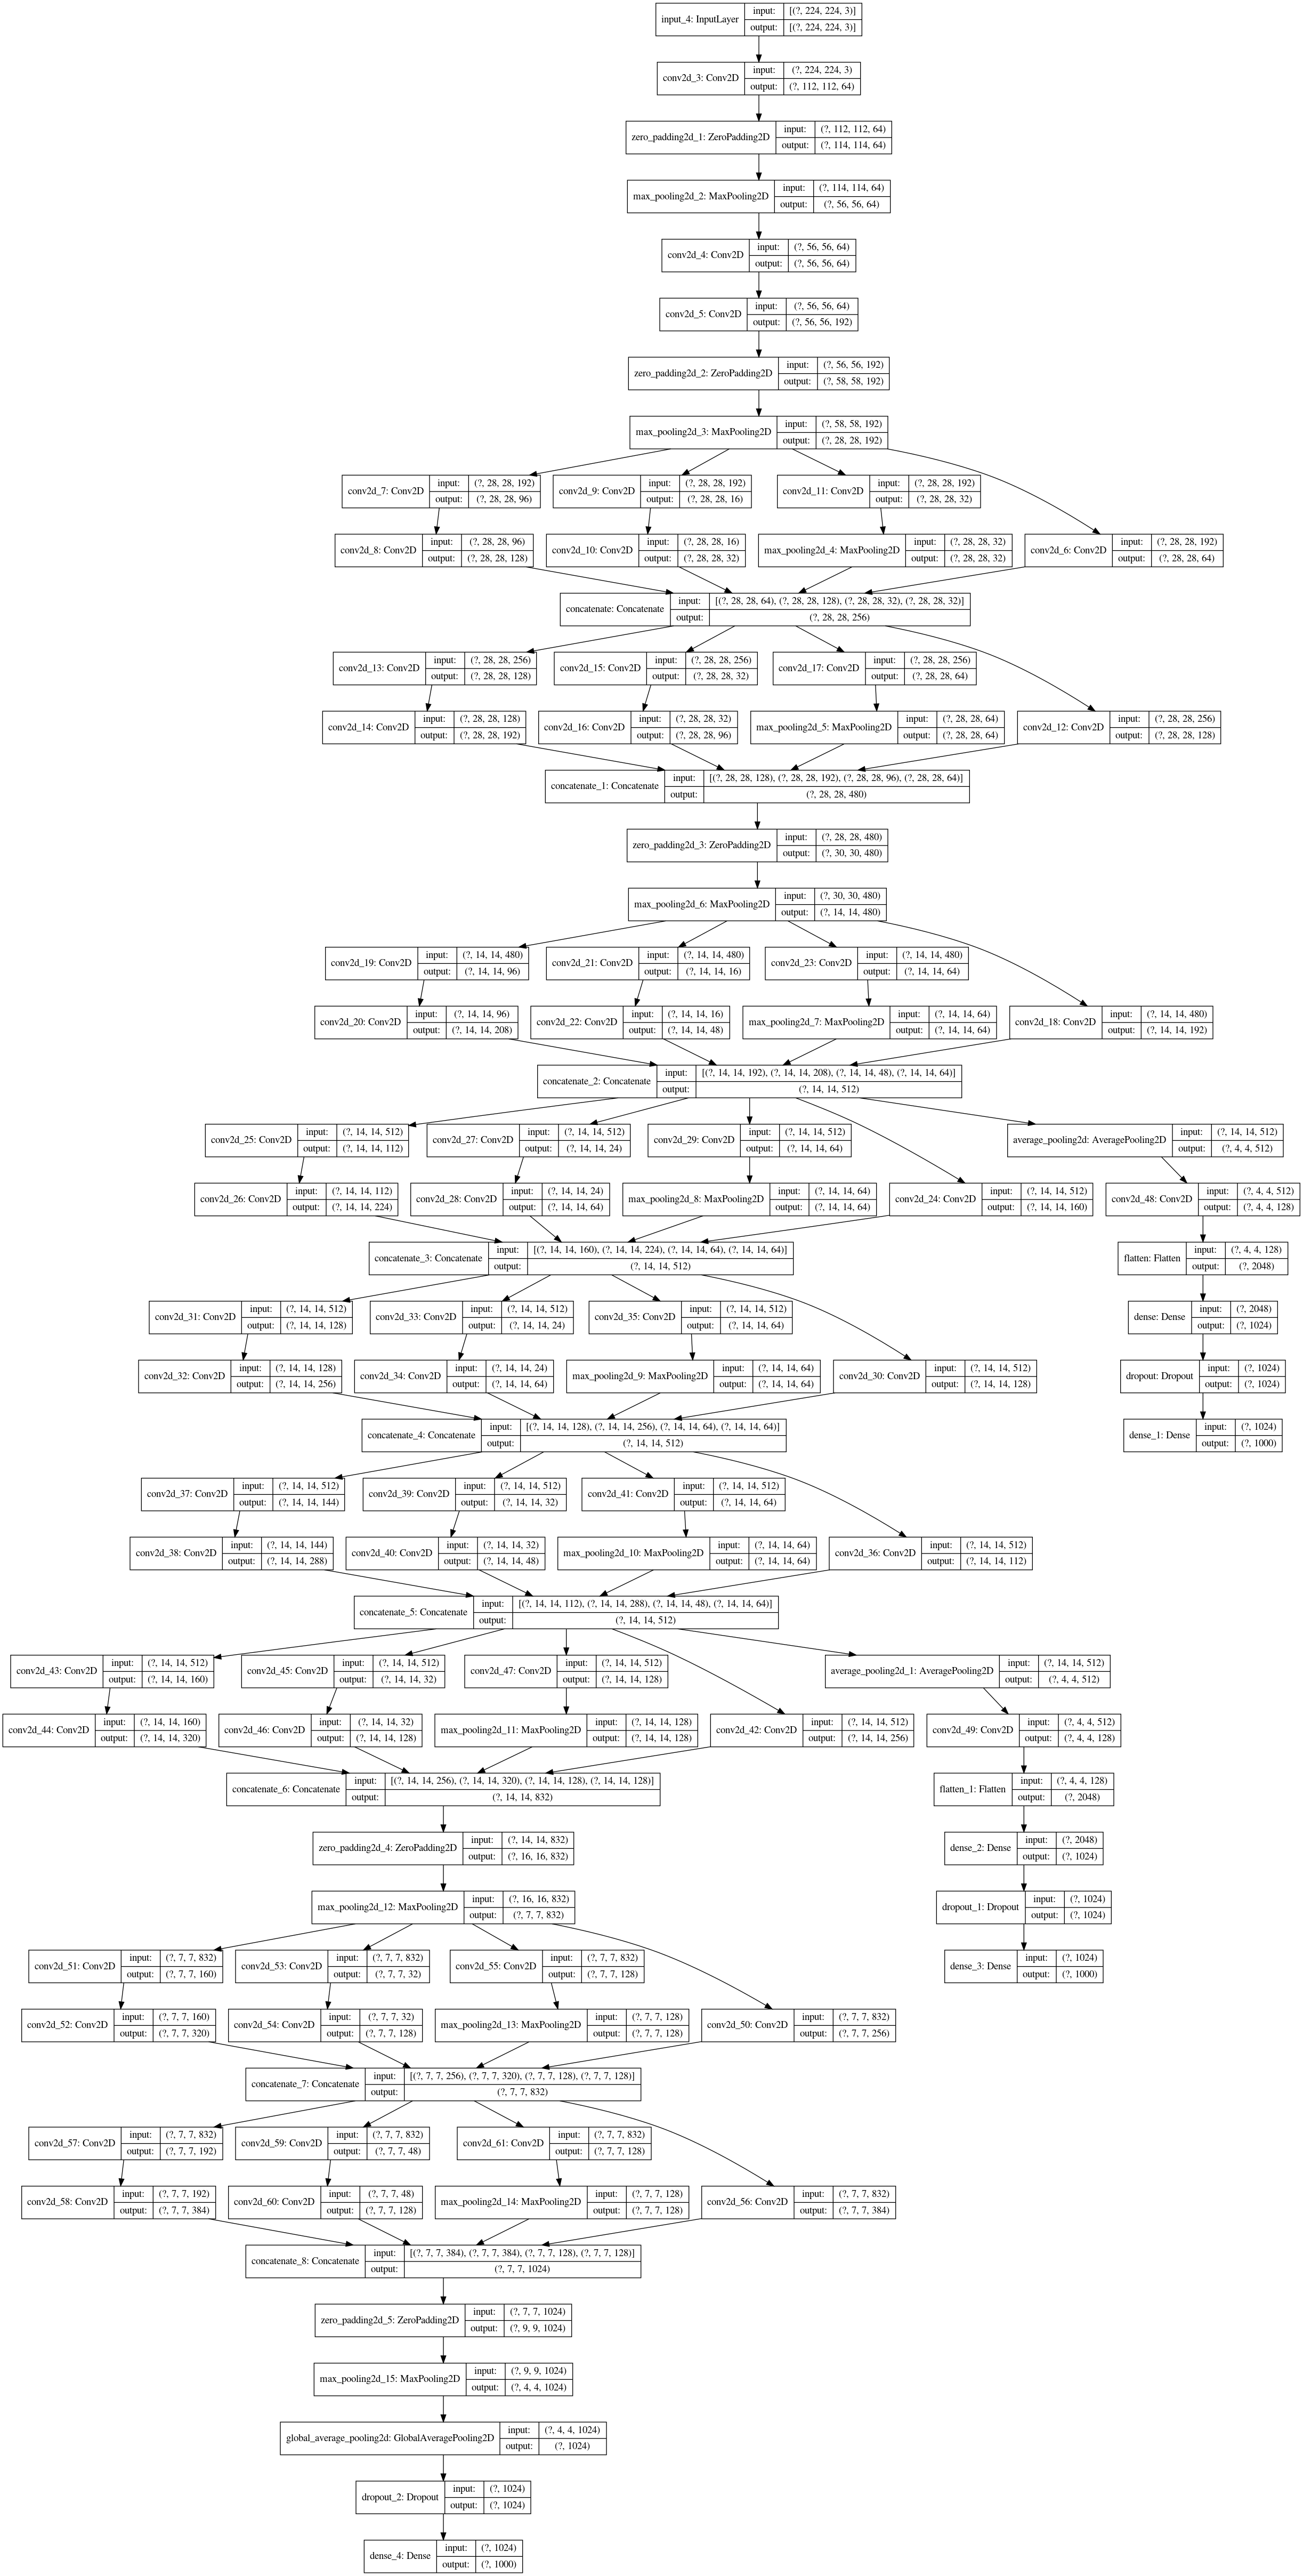

In [17]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [8]:
pad1.shape

TensorShape([None, 114, 114, 64])

In [12]:
pool1 = layers.MaxPool2D(3, 2)(conv1)

In [13]:
pool1.shape

TensorShape([None, 55, 55, 64])